<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/ep70tf_TransferLearning_JH_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Episod70t. Transfer Learning for Task Similarity (within industry effect)

Transfer learning attempts to teach a neural network from previously trained network. Rather than training your neural network from scratch, you begin training with a preloaded set of weights. Usually, you will remove the topmost layers of the pretrained neural network and retrain it with new uppermost layers. The layers from the previous neural network will be locked so that training does not change these weights. Only the newly added layers will be trained.

## Load Tensorflow 2.0
- The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [ ]:
# Start CoLab
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


## Step 1. Setup & Load Data

In [ ]:
# import libraries
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [ ]:
# Load Data
# I saved it on my local drive
from google.colab import files
uploaded = files.upload()

Saving CompA2019_inputdata2.csv to CompA2019_inputdata2.csv


In [ ]:
# read data into pandas DataFrame
df = pd.read_csv("CompA2019_inputdata2.csv")

In [ ]:
# fewer input variables
# df = df[["ff17","logq_f","lat_f","capx2a_f","che2a_f","cogs2a_f","dlc2a_f","dltt2a_f","emp2a_f","invt2a_f","ni2a_f","ppent2a_f","re2a_f","txt2a_f","xad2a_f","xint2a_f","xrd2a_f","xsga2a_f"]]
#df = df[["ff17","logq_f","lat_f","capx2a_f","dlc2a_f","dltt2a_f","emp2a_f","ppent2a_f","xad2a_f","xrd2a_f"]]
df = df[[
    "ff17",      # 산업 코드 (Fama–French 17) ─ 산업 구분용
    "logq_f",    # 로그 Tobin’s Q ─ 목표값(y)
    "lat_f",     # 총자산 로그 ─ 규모 지표
    "capx2a_f",  # 설비투자/자산
    "che2a_f",   # 현금·현금성/자산
    "cogs2a_f",  # 매출원가/자산
    "dlc2a_f",   # 단기부채/자산
    "dltt2a_f",  # 장기부채/자산
    "emp2a_f",   # 종업원수/자산
    "invt2a_f",  # 재고/자산
    "ni2a_f",    # 순이익/자산
    "ppent2a_f", # 유형자산(설비)/자산
    "re2a_f",    # 이익잉여금/자산
    "txt2a_f",   # 법인세비용/자산
    "xad2a_f",   # 광고비/자산
    "xint2a_f",  # 이자비용/자산
    "xrd2a_f",   # R&D/자산
    "xsga2a_f"   # 판매·관리비/자산
]]


In [ ]:
# task A (2 - Mines) & task B (3 - Oil)
# 15 - retail stores

#===> Change y variable of your choice below

dfA = df[df['ff17']==2]
dfB = df[df['ff17']==15]
print(dfA.shape, dfB.shape)

# drop ff17
dfA = dfA.drop(['ff17'], axis=1)
dfB = dfB.drop(['ff17'], axis=1)

# split data
RANDOM_SEED = 27 # fix train/test set
dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, random_state=RANDOM_SEED)
dfB_train, dfB_test = train_test_split(dfB, test_size=0.2, random_state=RANDOM_SEED)
# dfA_train, dfA_test = train_test_split(dfA, test_size=0.2)
# dfB_train, dfB_test = train_test_split(dfB, test_size=0.2)
print(dfA_train.shape, dfA_test.shape)
print(dfB_train.shape, dfB_test.shape)

# separate input (x) and output (y)
df_xA_train = dfA_train.loc[:, dfA_train.columns != 'logq_f']
df_yA_train = dfA_train.loc[:, dfA_train.columns == 'logq_f'] # q값이 목표
df_xA_test = dfA_test.loc[:, dfA_test.columns != 'logq_f']
df_yA_test = dfA_test.loc[:, dfA_test.columns == 'logq_f']

df_xB_train = dfB_train.loc[:, dfB_train.columns != 'logq_f']
df_yB_train = dfB_train.loc[:, dfB_train.columns == 'logq_f']
df_xB_test = dfB_test.loc[:, dfB_test.columns != 'logq_f']
df_yB_test = dfB_test.loc[:, dfB_test.columns == 'logq_f']

# convert to numpy
xA_train = df_xA_train.to_numpy()
yA_train = df_yA_train.to_numpy()
xA_test = df_xA_test.to_numpy()
yA_test = df_yA_test.to_numpy()

xB_train = df_xB_train.to_numpy()
yB_train = df_yB_train.to_numpy()
xB_test = df_xB_test.to_numpy()
yB_test = df_yB_test.to_numpy()

(402, 18) (226, 18)
(321, 17) (81, 17)
(180, 17) (46, 17)


In [ ]:
def dfA_model(i):
    dfA = df[df['ff17']==i]

    # drop ff17
    dfA = dfA.drop(['ff17'], axis=1)

    # split data
    RANDOM_SEED = 27 # fix train/test set
    dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, random_state=RANDOM_SEED)

    # separate input (x) and output (y)
    df_xA_train = dfA_train.loc[:, dfA_train.columns != 'logq_f']
    df_yA_train = dfA_train.loc[:, dfA_train.columns == 'logq_f'] # q값이 목표
    df_xA_test = dfA_test.loc[:, dfA_test.columns != 'logq_f']
    df_yA_test = dfA_test.loc[:, dfA_test.columns == 'logq_f']

    # convert to numpy
    xA_train = df_xA_train.to_numpy()
    yA_train = df_yA_train.to_numpy()
    xA_test = df_xA_test.to_numpy()
    yA_test = df_yA_test.to_numpy()

    # Build neural network
    modelA = Sequential()
    modelA.add(Dense(20, input_dim=xA_train.shape[1], activation='relu')) # Hidden 1. 20 neurons
    modelA.add(Dense(20, activation='relu')) # Hidden 2
    modelA.add(Dense(1)) # Output

    modelA.compile(loss='mean_squared_error', optimizer='adam')

    # train Iris classification network
    modelA.fit(xA_train,yA_train,verbose=False,epochs=100) # epoch = 100

    pred = modelA.predict(xA_test)
    score = np.sqrt(metrics.mean_squared_error(pred,yA_test))

    # Save the entire model as a SavedModel.
    modelA.save(f'saved_model/model_{i}.keras')

In [ ]:
!mkdir -p saved_model
for i in range(1, 18):
    dfA_model(i)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
# new_model = tf.keras.models.load_model('saved_model/model_1.keras')

# # Check its architecture
# new_model.summary()

NameError: name 'tf' is not defined

#각 모델 간의 RMSE Heatmap

In [ ]:
import os, numpy as np
from sklearn.model_selection import train_test_split

def xi_test_save(i, save_dir="saved_xi_test"):
    os.makedirs(save_dir, exist_ok=True)

    dfA = df[df["ff17"] == i].drop("ff17", axis=1)
    dfA_train, dfA_test = train_test_split(dfA, test_size=0.2, random_state=27)

    xA_test = dfA_test.drop("logq_f", axis=1).to_numpy()
    yA_test = dfA_test[["logq_f"]].to_numpy()

    np.save(os.path.join(save_dir, f"x{i}_test.npy"), xA_test)
    np.save(os.path.join(save_dir, f"y{i}_test.npy"), yA_test)

    print(f"[✔] ff17={i} test-set saved to “{save_dir}”")

In [ ]:
!mkdir -p saved_xi_test
for i in range(1, 18):
    xi_test_save(i)

[✔] ff17=1 test-set saved to “saved_xi_test”
[✔] ff17=2 test-set saved to “saved_xi_test”
[✔] ff17=3 test-set saved to “saved_xi_test”
[✔] ff17=4 test-set saved to “saved_xi_test”
[✔] ff17=5 test-set saved to “saved_xi_test”
[✔] ff17=6 test-set saved to “saved_xi_test”
[✔] ff17=7 test-set saved to “saved_xi_test”
[✔] ff17=8 test-set saved to “saved_xi_test”
[✔] ff17=9 test-set saved to “saved_xi_test”
[✔] ff17=10 test-set saved to “saved_xi_test”
[✔] ff17=11 test-set saved to “saved_xi_test”
[✔] ff17=12 test-set saved to “saved_xi_test”
[✔] ff17=13 test-set saved to “saved_xi_test”
[✔] ff17=14 test-set saved to “saved_xi_test”
[✔] ff17=15 test-set saved to “saved_xi_test”
[✔] ff17=16 test-set saved to “saved_xi_test”
[✔] ff17=17 test-set saved to “saved_xi_test”


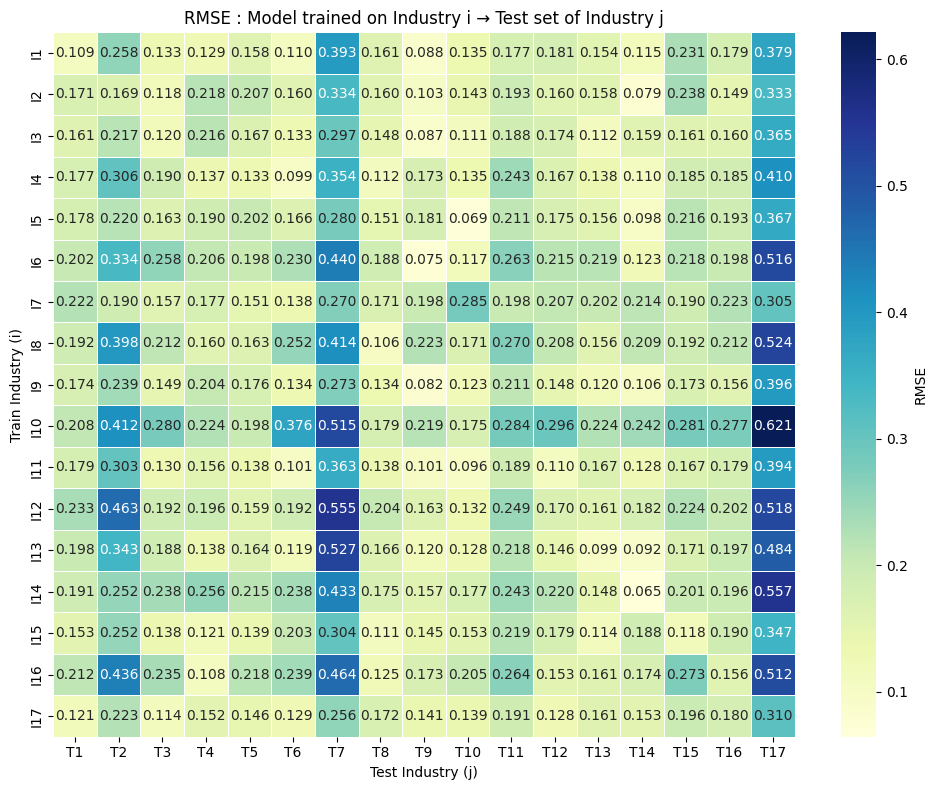

In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf


# 1) 경로 설정
# ------------------------------------------------------------------
WEIGHT_DIR = "saved_models"      # ff17_{i}_weights.h5
TEST_DIR   = "saved_xi_test"     # x{i}_test.npy, y{i}_test.npy
IND_LIST   = list(range(1, 18))  # 1 ~ 17


# 2) 데이터 로드 (산업마다 한 번씩)
# ------------------------------------------------------------------
x_tests, y_tests = {}, {}
for j in IND_LIST:
    x_tests[j] = np.load(os.path.join(TEST_DIR, f"x{j}_test.npy"))
    y_tests[j] = np.load(os.path.join(TEST_DIR, f"y{j}_test.npy"))


# 3) RMSE 매트릭스 계산
# ------------------------------------------------------------------
rmse_mat = np.zeros((17, 17))

for i in IND_LIST:
    base_model = tf.keras.models.load_model(f'saved_model/model_{i}.keras')

    # 4-2) industry i → industry j 예측
    for j in IND_LIST:
        y_pred = base_model.predict(x_tests[j], verbose=0)
        rmse   = np.sqrt(mean_squared_error(y_tests[j], y_pred))
        rmse_mat[i-1, j-1] = rmse         # 인덱스 0-based


# 4) 히트맵 시각화
# ------------------------------------------------------------------
rmse_df = pd.DataFrame(rmse_mat, index=[f"I{i}" for i in IND_LIST],
                                     columns=[f"T{j}" for j in IND_LIST])

plt.figure(figsize=(10, 8))
sns.heatmap(rmse_df,
            annot=True, fmt=".3f",
            cmap="YlGnBu", linewidths=.5,
            cbar_kws={"label": "RMSE"})
plt.title("RMSE : Model trained on Industry i → Test set of Industry j")
plt.xlabel("Test Industry (j)")
plt.ylabel("Train Industry (i)")
plt.tight_layout()
plt.show()

# K형 산업 / L형 산업 2가지로 분류

In [ ]:
import numpy as np, pandas as pd

def make_KL_labels(df_full, ind_col="ff17",
                   k_var="ppent2a_f",    # PP&E / assets  → capital ratio
                   l_var="emp2a_f"):     # Employees / assets → labor ratio
    """
    Returns a dict  {industry_code: 'K' or 'L'}
    rule: industry-average capital_ratio  >  labor_ratio  → 'K', else 'L'
    """
    g = df_full.groupby(ind_col)[[k_var, l_var]].mean()
    labels = (g[k_var] > g[l_var]).map({True:"K", False:"L"}).to_dict()
    return labels, g         # also return the table for inspection


In [ ]:
labels, _ = make_KL_labels(df)            # df = raw panel with ratios
lab_series  = pd.Series(labels)           # index = 1…17, values 'K'/'L'

# reuse rmse_df created earlier (rows = I1…17, cols = T1…17)
rmse_df.index  = lab_series.index         # 1…17
rmse_df.columns= lab_series.index

# boolean masks
row_isK = lab_series == "K"
row_isL = lab_series == "L"
col_isK = row_isK.copy()
col_isL = row_isL.copy()

within_K  = rmse_df.loc[row_isK, col_isK].values.ravel()
within_L  = rmse_df.loc[row_isL, col_isL].values.ravel()
cross_K2L = rmse_df.loc[row_isK, col_isL].values.ravel()
cross_L2K = rmse_df.loc[row_isL, col_isK].values.ravel()
cross_all = np.concatenate([cross_K2L, cross_L2K])
within_all= np.concatenate([within_K, within_L])


In [ ]:
from scipy.stats import ttest_ind
tstat, pval = ttest_ind(cross_all, within_all, equal_var=False)

print(f"within mean  = {within_all.mean():.3f}")
print(f"cross  mean  = {cross_all.mean():.3f}")
print(f"Welch-t p-value (one-sided) = {pval/2:.4f}")


within mean  = 0.207
cross  mean  = 0.208
Welch-t p-value (one-sided) = 0.4779


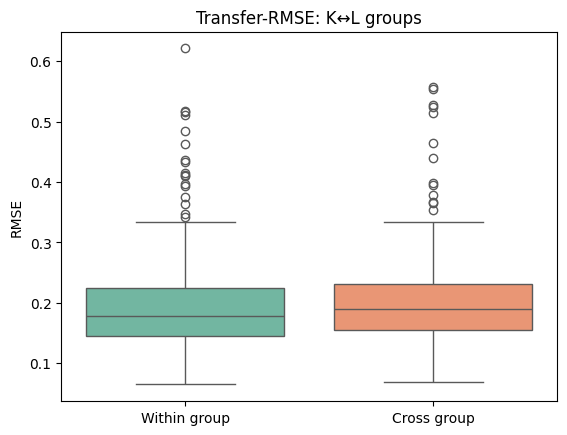

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(data=[within_all, cross_all], palette=["#66c2a5", "#fc8d62"])
plt.xticks([0,1], ["Within group", "Cross group"])
plt.ylabel("RMSE")
plt.title("Transfer-RMSE: K↔L groups")
plt.show()


# K(30%), N 중립(40%), L(30%)로 분류


### Group membership
         Group
Industry      
1            N
2            L
3            N
4            N
5            K
6            N
7            N
8            N
9            N
10           N
11           K
12           N
13           N
14           N
15           N
16           L
17           N

=== Sharper K/L test (top30 vs bottom30) ===
within mean  = 0.206
cross  mean  = 0.222
one-sided Welch-t p-value = 0.3377


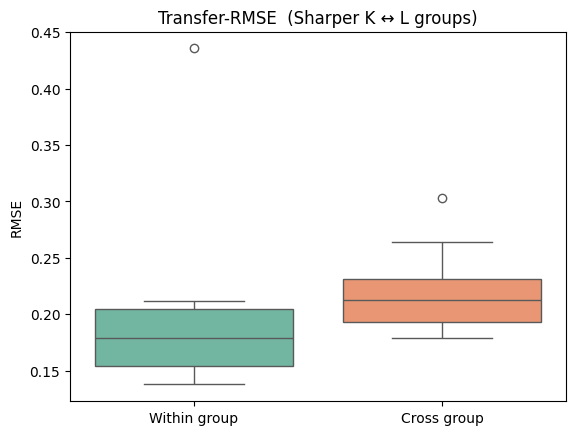

In [ ]:
# ------------------------------------------------------------
# 필요한 패키지
# ------------------------------------------------------------
import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 원본 패널: df  (각 firm-year × 재무비율)
# RMSE 행렬  : rmse_df  (index & columns == 1 … 17)
# ------------------------------------------------------------

# 1. Capital- vs. Labor-intensity 지수 계산 ---------------------
#    - CapitalIndex  = PP&E/Assets  +  CAPEX/Assets
#    - LaborIndex    = Employees/Assets  +  SG&A/Assets

# TODO
# 정규화. scaling 작업 필요. 회사 사이즈에 영향 X 산업별 차이를 보이기 위해서.
# 변수별 소그룹 내의 분포를 시각화 - outlier
# 모든 변수를 scale하지 않고 위 변수들만 scaling
# 회의때 설명할 내용 정리해서 워드파일로 작성
#
cap_vars = ['ppent2a_f', 'capx2a_f']
lab_vars = ['emp2a_f',  'xsga2a_f']

g = df.groupby('ff17')[cap_vars + lab_vars].mean()
g['CapitalIdx'] = g[cap_vars].sum(axis=1)
g['LaborIdx']   = g[lab_vars].sum(axis=1)
g['Diff']       = g['CapitalIdx'] - g['LaborIdx']      # (+) = capital-heavy

# 2. 30–30–40 퍼센타일 컷으로 라벨링 ---------------------------
top_th   = g['Diff'].quantile(0.90)   # 상위 30 % -> 조정
bottom_th= g['Diff'].quantile(0.10)   # 하위 30 %

def assign_label(x):
    if   x >= top_th:    return 'K'
    elif x <= bottom_th: return 'L'
    else:                return 'N'

labels = g['Diff'].apply(assign_label).to_dict()   # {ff17_code: 'K'/'L'/'N'}
lab_series = pd.Series(labels)

print("\n### Group membership")
print(pd.DataFrame({'Industry': lab_series.index,
                    'Group'   : lab_series.values})
        .set_index('Industry')
        .sort_index())

# 3.  RMSE 행렬에 라벨 적용 -----------------------------------
rmse_df.index   = lab_series.index      # 1 … 17
rmse_df.columns = lab_series.index

isK = lab_series == 'K'
isL = lab_series == 'L'

within_K  = rmse_df.loc[isK, isK].to_numpy().ravel()
within_L  = rmse_df.loc[isL, isL].to_numpy().ravel()
cross_K2L = rmse_df.loc[isK, isL].to_numpy().ravel()
cross_L2K = rmse_df.loc[isL, isK].to_numpy().ravel()

within_all = np.concatenate([within_K, within_L])
cross_all  = np.concatenate([cross_K2L, cross_L2K])

# 4. Welch-t (one-sided) --------------------------------------
tstat, p_two = ttest_ind(cross_all, within_all, equal_var=False)
p_one = p_two / 2        # H1: cross > within

print(f"\n=== Sharper K/L test (top30 vs bottom30) ===")
print(f"within mean  = {within_all.mean():.3f}")
print(f"cross  mean  = {cross_all.mean():.3f}")
print(f"one-sided Welch-t p-value = {p_one:.4f}")

# 5. 시각화 ----------------------------------------------------
sns.boxplot(data=[within_all, cross_all],
            palette=['#66c2a5', '#fc8d62'])
plt.xticks([0,1], ['Within group', 'Cross group'])
plt.ylabel('RMSE'); plt.title('Transfer-RMSE  (Sharper K ↔ L groups)')
plt.show()


## Step 2. ModelA with Task A (best case for Task A)

In [ ]:
# Build neural network
modelA = Sequential()
modelA.add(Dense(20, input_dim=xA_train.shape[1], activation='relu')) # Hidden 1. 20 neurons
modelA.add(Dense(20, activation='relu')) # Hidden 2
modelA.add(Dense(1)) # Output

modelA.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train Iris classification network
modelA.fit(xA_train,yA_train,verbose=False,epochs=100) # epoch = 100

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelA.predict(xA_test)
score = np.sqrt(metrics.mean_squared_error(pred,yA_test))
print(f"Final score (RMSE) Model A with Task A: {score}")

## Step 3. Clone ModelA (trained for Task A) with Task A (Same as above)

In [ ]:
# clone network
modelA_clone = Sequential()
for layer in modelA.layers:
    modelA_clone.add(layer)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelA_clone.predict(xA_test)
score = np.sqrt(metrics.mean_squared_error(pred,yA_test))
print(f"Final score (RMSE) Model A Clone with Task A: {score}")

## Step 4.Use Cloned ModelA with Task B (Full Transfer Learning A for task B)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelA_clone.predict(xB_test)
score = np.sqrt(metrics.mean_squared_error(pred,yB_test))
print(f"Final score (RMSE) ModelA Clone with Task B: {score}")

## Step 5. Train ModelB with Task B (best case for Task B)

In [ ]:
# Build neural network
modelB = Sequential()
modelB.add(Dense(20, input_dim=xB_train.shape[1], activation='relu')) # Hidden 1
modelB.add(Dense(20, activation='relu')) # Hidden 2
modelB.add(Dense(1)) # Output

modelB.compile(loss='mean_squared_error', optimizer='adam')

# train Iris classification network
modelB.fit(xB_train,yB_train,verbose=False,epochs=100)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelB.predict(xB_test)
score = np.sqrt(metrics.mean_squared_error(pred,yB_test))
print(f"Final score (RMSE) Model B with Task B: {score}")

## Step 6. Recycle ModelA except last layer with Task B (Partial Transfer Learning A for Task B)

In [ ]:
# copy first two layers of the trained iris classification network
modelAx = Sequential()
for i in range(2):
    layer = modelA.layers[i]
    layer.trainable = False
    modelAx.add(layer)

# summery of the copied model
modelAx.summary()

In [ ]:
# We add a final regression output layer to complete the new neural network.
modelAx.add(Dense(1)) # Output

In [ ]:
# compile iris cost regression network
modelAx.compile(loss='mean_squared_error', optimizer='adam')

# summery of iris cost regression network
modelAx.summary()

In [ ]:
# Train the last layer of the network
modelAx.fit(xB_test,yB_test,verbose=False,epochs=100)

In [ ]:
# Evaluate the in-sample RMSE for the new model containing transferred layers from the previous model.
from sklearn.metrics import accuracy_score
pred = modelAx.predict(xB_test)
score = np.sqrt(metrics.mean_squared_error(pred,yB_test))
print(f"Final score (RMSE) Model A (except last layer) with Task B: {score}")